<a href="https://www.kaggle.com/code/samarchhetri/credit-risk-prediction-imbalance-balance-data?scriptVersionId=121956755" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/german-credit-data-with-risk/german_credit_data.csv


##### This a personal project I did for learning and understanding how to build machine learning models in a step by step processs. I am a beginner in ML and still learning. So if there are any mistakes it will be very helpful if you point it out.
#### Any type of questions, suggesstions is gladly accespted

### Problem Overview

##### In banks, providing credit is a tough decision. Analysing the risk regarding the sanction of credit is an important steps. If banks do so, then they could analyse the risk factors so that they slow down or resist providing bad credits.

##### In this project, we will use German Credit Dataset to figure our if the credit possess risk or not. We will also automate the whole process.

### Obstacles:
* The dataset is not balanced. So, we have to handle it

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
loan_data = pd.read_csv('/kaggle/input/german-credit-data-with-risk/german_credit_data.csv')
loan_data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
# Structure of dataset
rows = loan_data.shape[0]
columns = loan_data.shape[1]
print(f'There are {rows} rows and {columns} features in the dataset')

There are 1000 rows and 11 features in the dataset


In [5]:
# General info
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [6]:
# Checking datatypes
loan_data.dtypes

Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [7]:
# Categorical features
cat_cols = loan_data.select_dtypes('object').columns
# Numerical features
num_cols = loan_data.select_dtypes(exclude='object').columns

### Data Cleaning

In [8]:
# Checking for duplicates
loan_data.duplicated().sum()

0

In [9]:
# Checking for missing values
loan_data.isna().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [10]:
# Checking the percent of missing cells
total_cells = rows * columns
missing_cells = loan_data.isna().sum().sum()
missing_percent = (missing_cells/ total_cells)*100
print(f'Percent of missing values is {missing_percent} %')

Percent of missing values is 5.245454545454545 %


##### As can be seen, percent of missing values is acceptable. We will use different tecvhniques to impute them.

In [11]:
# Checking for cardinality
loan_data[cat_cols].nunique().sort_values(ascending=False)

Purpose             8
Saving accounts     4
Housing             3
Checking account    3
Sex                 2
Risk                2
dtype: int64

In [12]:
# Checking for misspelled words
for col in cat_cols:
    unique = loan_data[col].unique()
    print(f'For {col} : {unique}')

For Sex : ['male' 'female']
For Housing : ['own' 'free' 'rent']
For Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
For Checking account : ['little' 'moderate' nan 'rich']
For Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
For Risk : ['good' 'bad']


##### There is not any mis-spelled words in our features

In [13]:
# Checking mis-typed numbers
for col in num_cols:
    min_value = loan_data[col].min()
    max_value = loan_data[col].max()
    print(f'Range for {col} : [{min_value} to {max_value}]')

Range for Unnamed: 0 : [0 to 999]
Range for Age : [19 to 75]
Range for Job : [0 to 3]
Range for Credit amount : [250 to 18424]
Range for Duration : [4 to 72]


##### Numbers also looks fine.

In [14]:
# here \s+ means select all those which has one or more white sapces
# replace them with just one space

loan_data[cat_cols].replace('\s+', ' ', regex=True, inplace=True)

In [15]:
# Remove spaces
def remove_spaces(df, column):
    df[column] = df[column].str.strip()
    return df[column]

# Executing it
for col in cat_cols:
    loan_data[col] = remove_spaces(loan_data, col)

### Exploratory Data Analysis

* Target feature analysis
* Categorical and Numerical features analysis

#### Analysing target feature

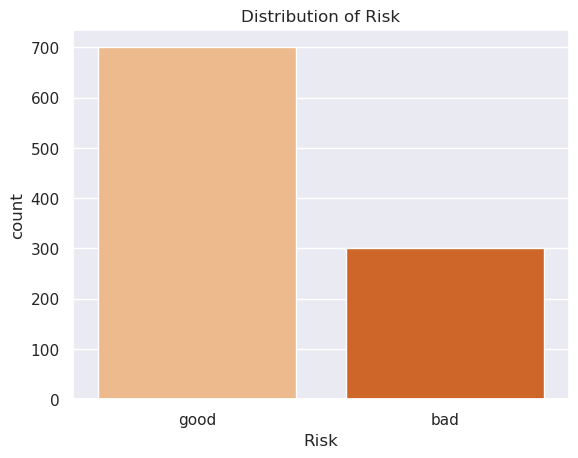

In [16]:
sns.countplot(x=loan_data['Risk'], palette='Oranges')
plt.title('Distribution of Risk')
plt.show()

##### As can be seen, the 'Good' class is purely dominating the 'Bad' class. This is an unbalanced dataset. We need to balance it using appropriate techniques

<AxesSubplot:ylabel='Risk'>

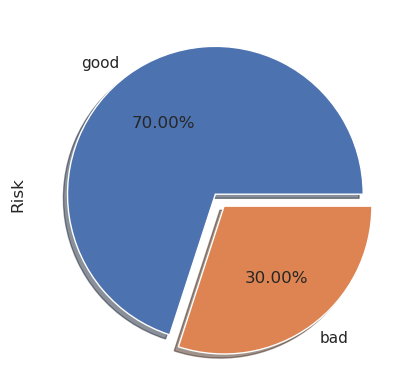

In [17]:
# Using pie chart
loan_data['Risk'].value_counts().plot(kind='pie', autopct='%1.2f%%', explode=[0,0.1], shadow=True)

#### Analysing Categorical features

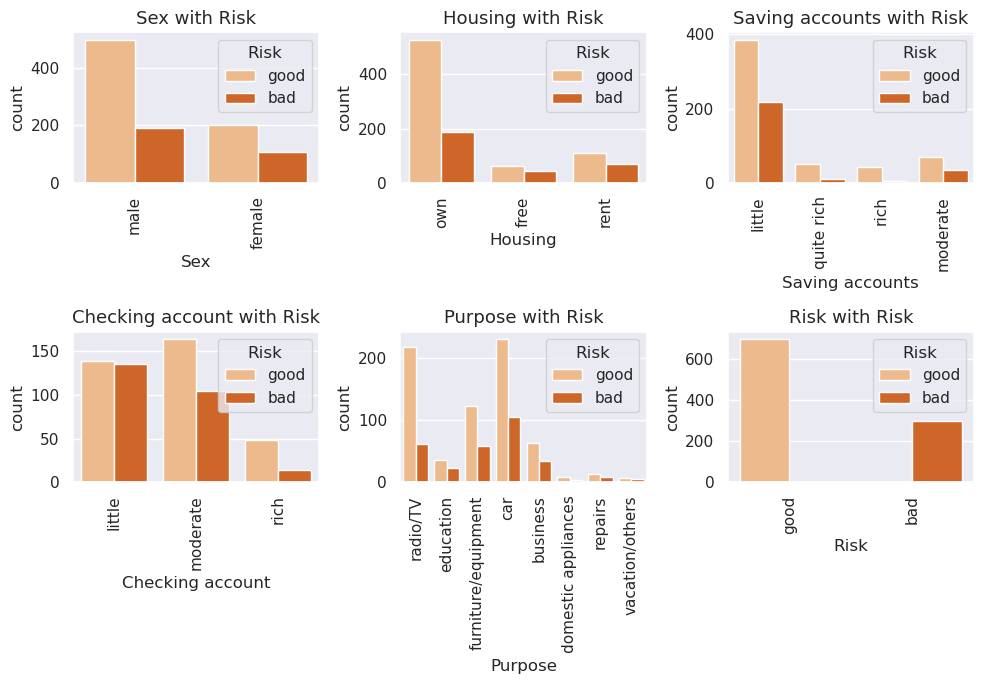

In [18]:
plt.figure(figsize=(10,7))
for index, col in enumerate(cat_cols):
    plt.subplot(2,3, index+1)
    sns.countplot(x=col, hue='Risk', data=loan_data, palette='Oranges')
    plt.title(f'{col} with Risk', fontsize=13)
    plt.xticks(rotation=90)
plt.tight_layout()

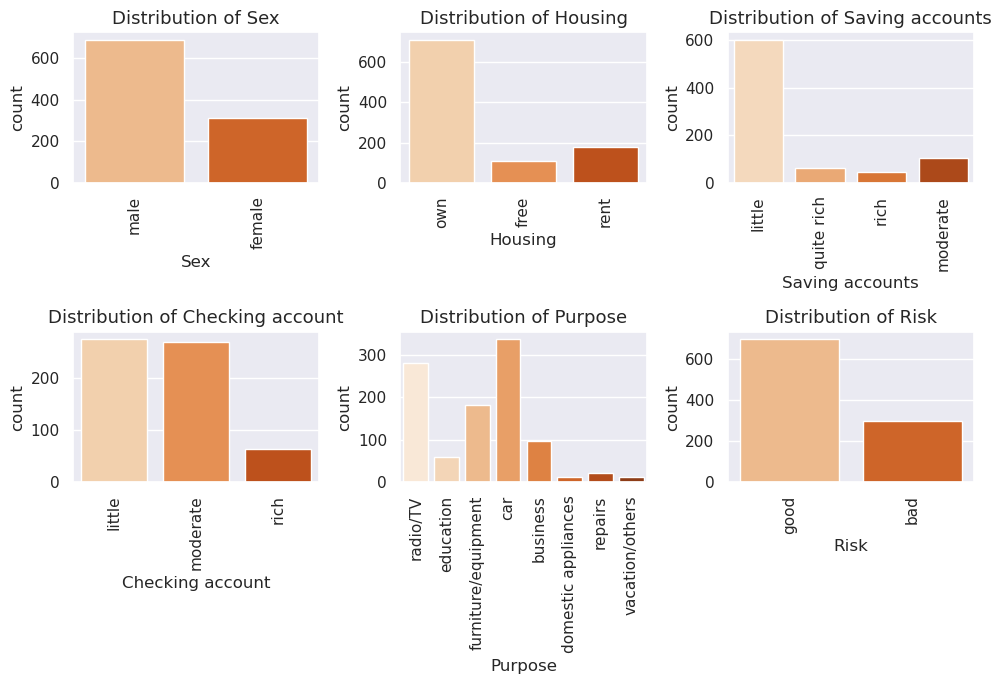

In [19]:
# Individual frequency plot
plt.figure(figsize=(10,7))
for index, col in enumerate(cat_cols):
    plt.subplot(2,3, index+1)
    sns.countplot(x=col, palette='Oranges', data= loan_data)
    plt.title(f'Distribution of {col}', fontsize=13)
    plt.xticks(rotation=90)
plt.tight_layout()

#### Analysing Continuous features

In [20]:
# Removing 'Unnamed' feature 
num_cols = num_cols.difference(['Unnamed: 0'])

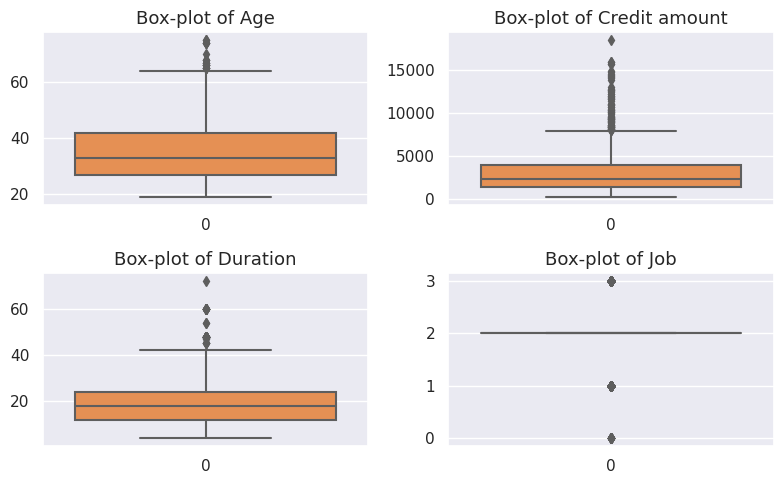

In [21]:
plt.figure(figsize=(8,5))
for index, col in enumerate(num_cols):
    plt.subplot(2,2, index+1)
    sns.boxplot(loan_data[col], palette='Oranges')
    plt.title(f'Box-plot of {col}', fontsize=13)
    
plt.tight_layout()

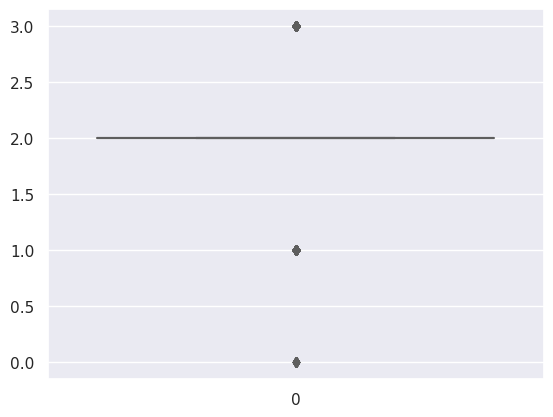

In [22]:
# Job feature
sns.boxplot(loan_data['Job'], palette='Oranges')
plt.show()

In [23]:
loan_data['Job'].value_counts()
# As can be seen, Job class 2 is clearly dominating other classes. That' why, our boxplot is weird.

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

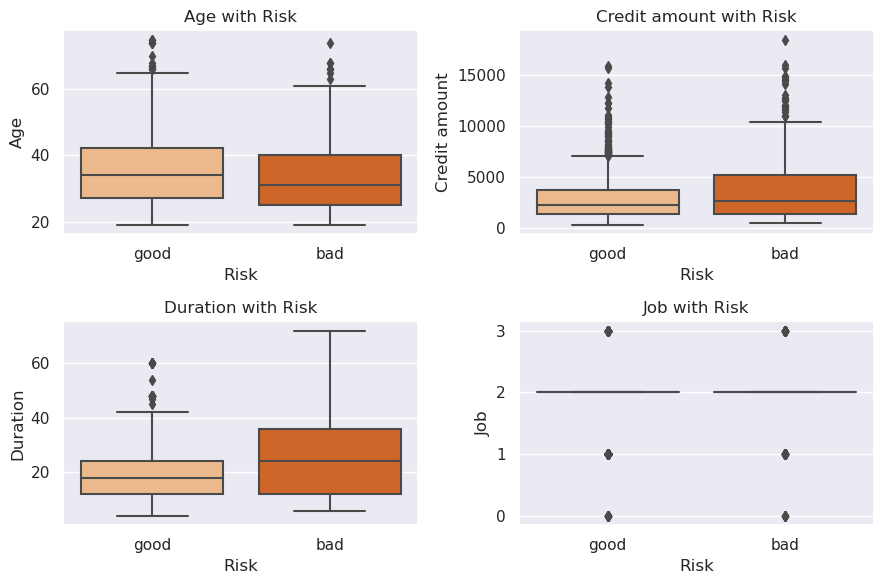

In [24]:
plt.figure(figsize=(9,6))
for index, col in enumerate(num_cols):
    plt.subplot(2,2, index+1)
    sns.boxplot(x='Risk', y=col, palette='Oranges', data=loan_data)
    plt.title(f'{col} with Risk')
    
plt.tight_layout()

##### As can be seen, higher the duration, higher would be risk. Same applies for credit amount feature also.

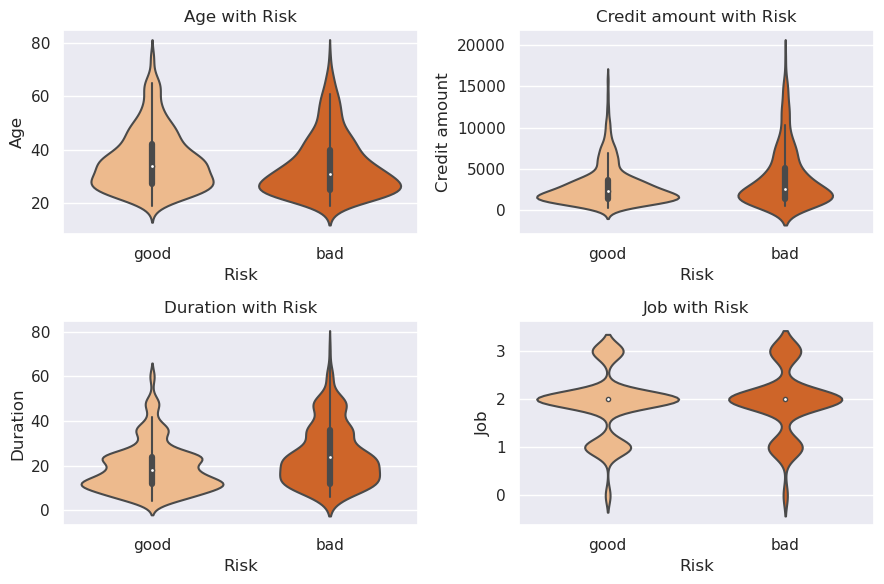

In [25]:
# Using violin plot
plt.figure(figsize=(9,6))
for index, col in enumerate(num_cols):
    plt.subplot(2,2, index+1)
    sns.violinplot(x='Risk', y=col, palette='Oranges', data=loan_data)
    plt.title(f'{col} with Risk')
    
plt.tight_layout()

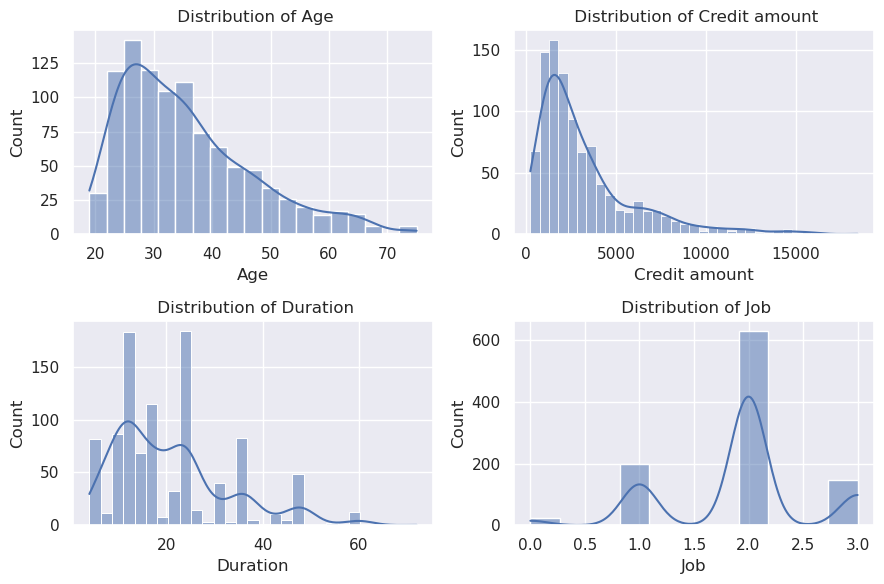

In [26]:
plt.figure(figsize=(9,6))
for index, col in enumerate(num_cols):
    plt.subplot(2,2, index+1)
    sns.histplot(x=col, kde= True, data=loan_data)
    plt.title(f' Distribution of {col}')
    
plt.tight_layout()

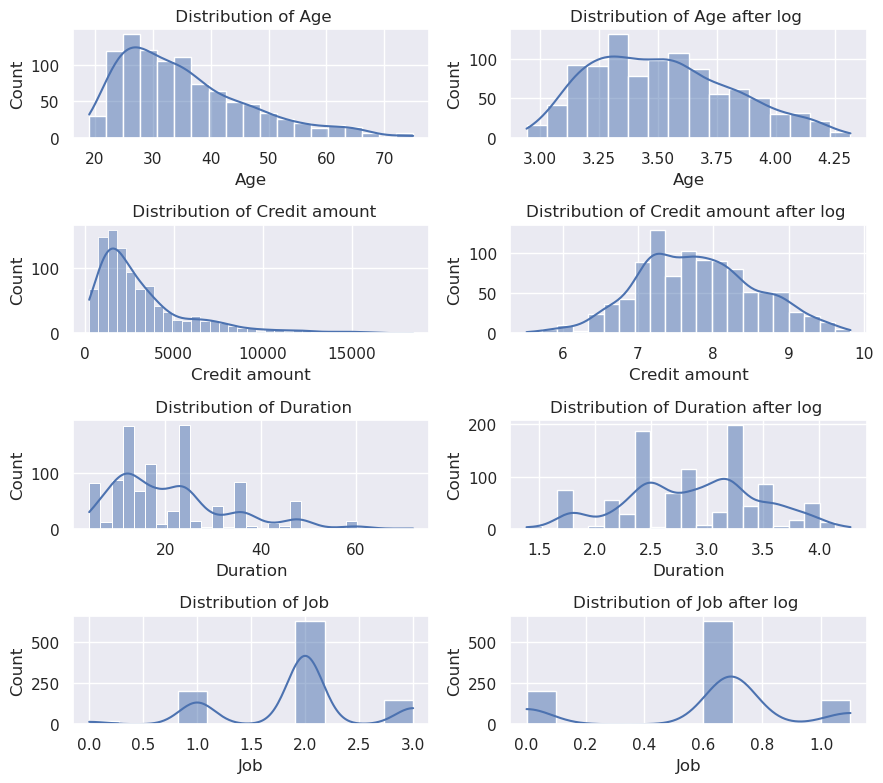

In [27]:
plt.figure(figsize=(9,8))
for index, col in enumerate(num_cols):
    plt.subplot(4,2, 2*index+1)
    sns.histplot(x=loan_data[col], kde= True)
    plt.title(f' Distribution of {col}')
    
    plt.subplot(4,2, 2*index+2)
    sns.histplot(x= np.log(loan_data[col]), kde=True, data = loan_data)
    plt.title(f'Distribution of {col} after log ')
    
plt.tight_layout()

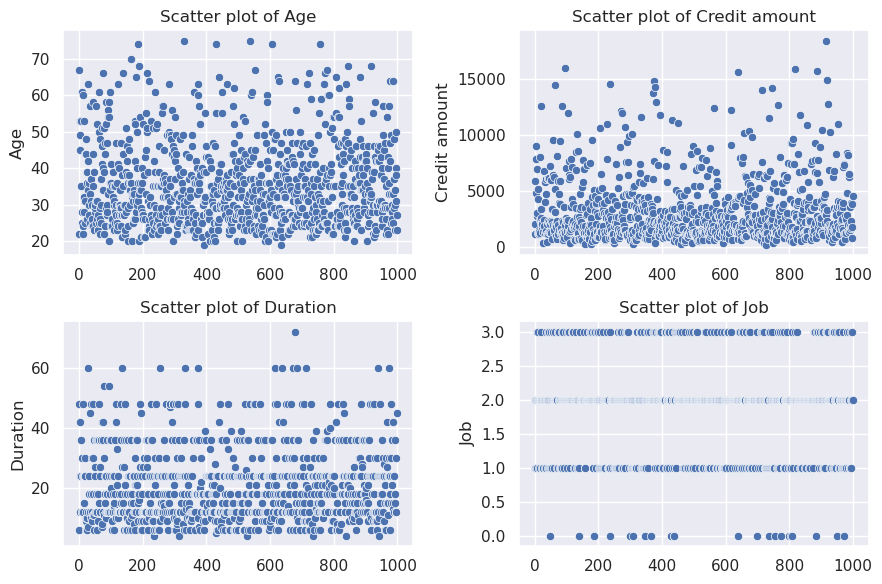

In [28]:
plt.figure(figsize=(9,6))
for index, col in enumerate(num_cols):
    plt.subplot(2,2, index+1)
    sns.scatterplot(loan_data[col])
    plt.title(f'Scatter plot of {col}')
plt.tight_layout()

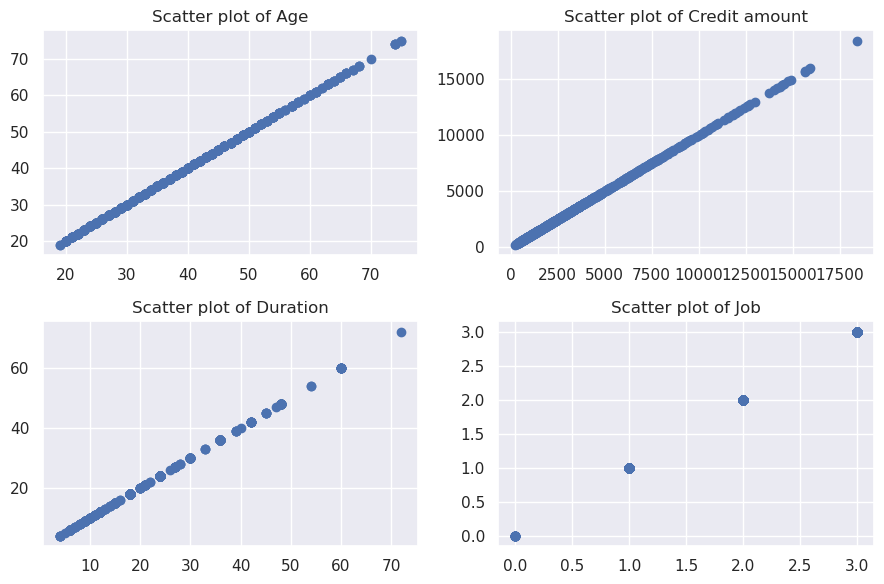

In [29]:
plt.figure(figsize=(9,6))
for index, col in enumerate(num_cols):
    plt.subplot(2,2, index+1)
    plt.scatter(x= loan_data[col], y=loan_data[col])
    plt.title(f'Scatter plot of {col}')
plt.tight_layout()

##### In the figure, you can see some data points are outliers.

<Figure size 600x400 with 0 Axes>

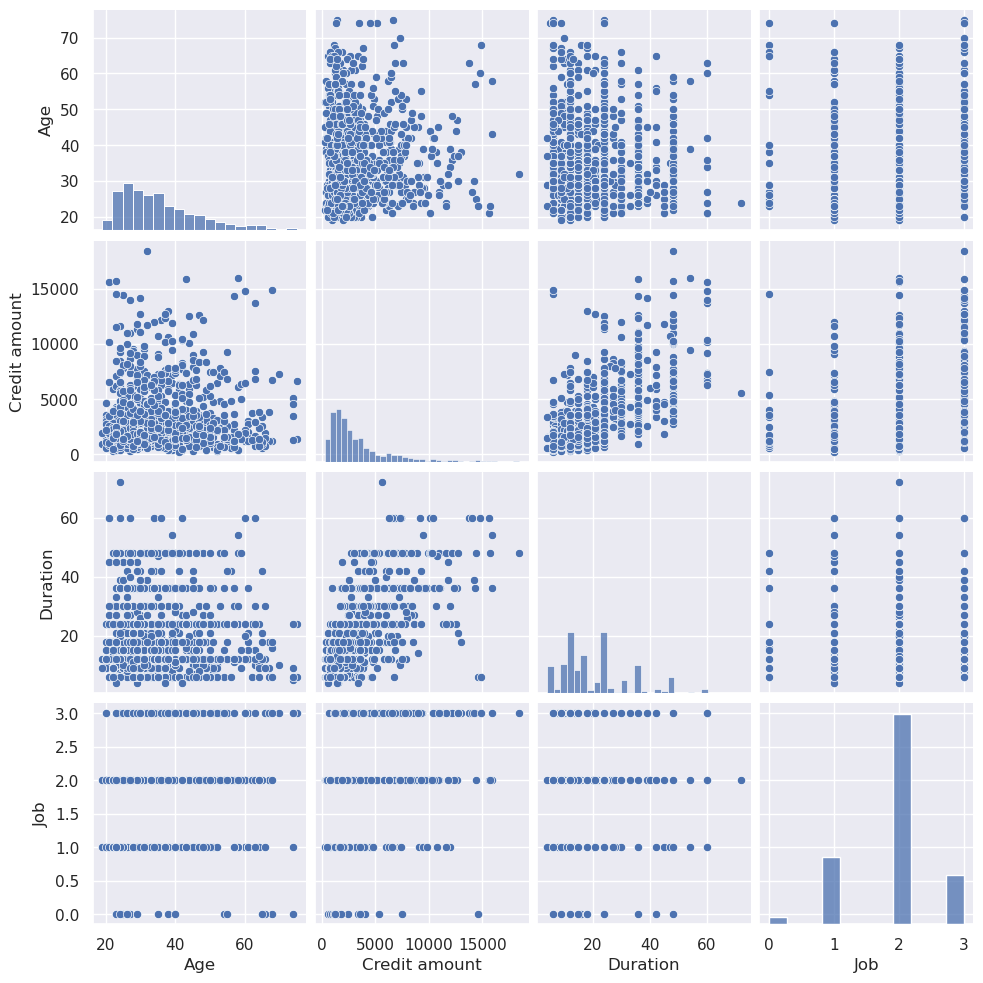

In [30]:
# Pairplot
plt.figure(figsize=(6,4))
sns.pairplot(loan_data[num_cols])
plt.show()

In [31]:
# Balancing the data for analytical purpose
bad_counts = loan_data['Risk'].value_counts()['bad']

good_counts_sample = loan_data[loan_data['Risk']=='good'].sample(bad_counts)
bad_counts_sample = loan_data[loan_data['Risk']=='bad']

# Concatinating both sample
loan_data_sample = pd.concat([good_counts_sample, bad_counts_sample])
loan_data_sample['Risk'].value_counts()

good    300
bad     300
Name: Risk, dtype: int64

In [32]:
loan_data_sample

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
202,202,26,male,2,own,little,NaN,5117,27,business,good
397,397,46,male,2,own,little,little,2348,36,furniture/equipment,good
904,904,36,male,3,own,little,NaN,1278,24,radio/TV,good
890,890,43,male,3,own,little,little,2442,27,business,good
239,239,39,male,2,own,little,little,2522,30,radio/TV,good
...,...,...,...,...,...,...,...,...,...,...,...
979,979,25,male,2,rent,moderate,moderate,1264,15,car,bad
980,980,49,male,2,own,little,moderate,8386,30,furniture/equipment,bad
981,981,33,male,3,rent,little,NaN,4844,48,business,bad
983,983,26,male,2,own,little,little,8229,36,car,bad


In [33]:
loan_data.describe().loc[['mean', 'std']]

,Unnamed: 0,Age,Job,Credit amount,Duration
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814


In [34]:
loan_data_sample.describe().loc[['mean', 'std']]

,Unnamed: 0,Age,Job,Credit amount,Duration
mean,507.988333,35.340000,1.921667,3497.251667,22.280000
std,290.728682,11.299729,0.652871,3030.919491,12.523431


##### Here, our sample looks normal.

In [35]:
cat_cols

Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose',
       'Risk'],
      dtype='object')

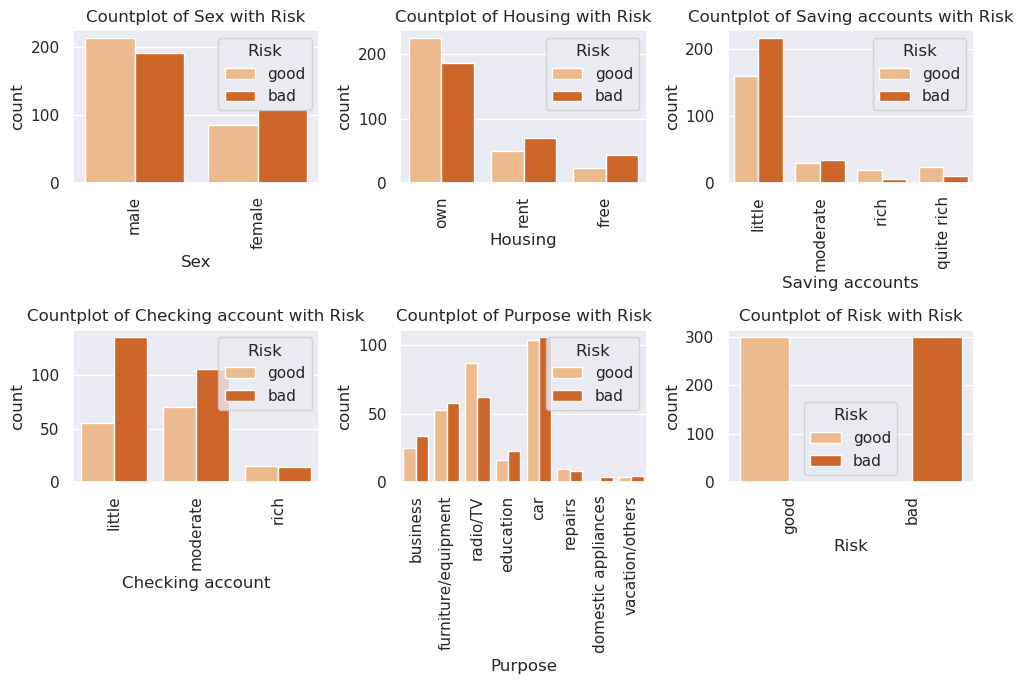

In [36]:
# Categorical features analysis on new sample data
plt.figure(figsize=(10,7))
for index, col in enumerate(cat_cols):
    plt.subplot(2,3, index+1)
    sns.countplot(x=col, hue='Risk', data=loan_data_sample, palette='Oranges')
    plt.title(f'Countplot of {col} with Risk')
    plt.xticks(rotation=90)
plt.tight_layout()

##### Features like Sex, Housing, Saving account, Checking account, Purpose,etc have effect on target feature.

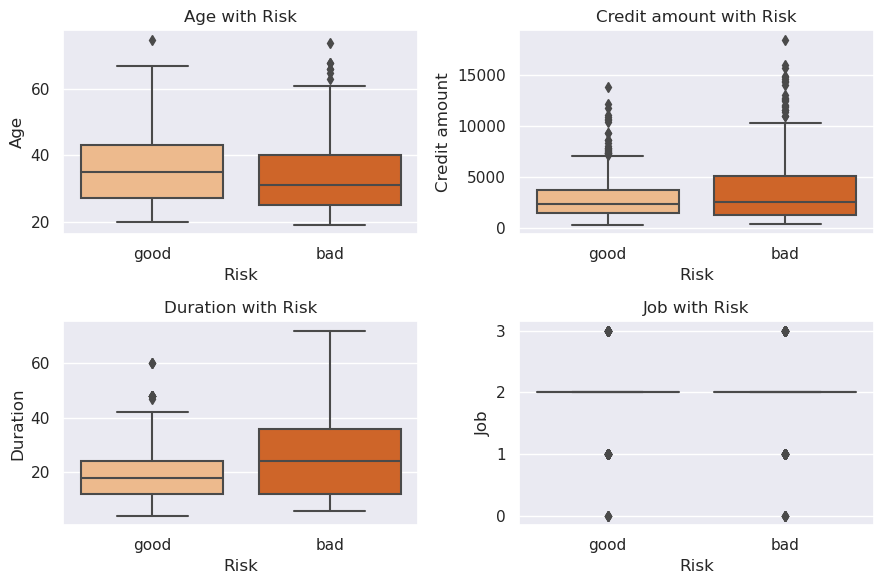

In [37]:
plt.figure(figsize=(9,6))
for index, col in enumerate(num_cols):
    plt.subplot(2,2, index+1)
    sns.boxplot(x='Risk', y=col, palette='Oranges', data=loan_data_sample)
    plt.title(f'{col} with Risk')
    
plt.tight_layout()

##### Features like Age, Credit amount, Duration and Job are also creating effect on target feature

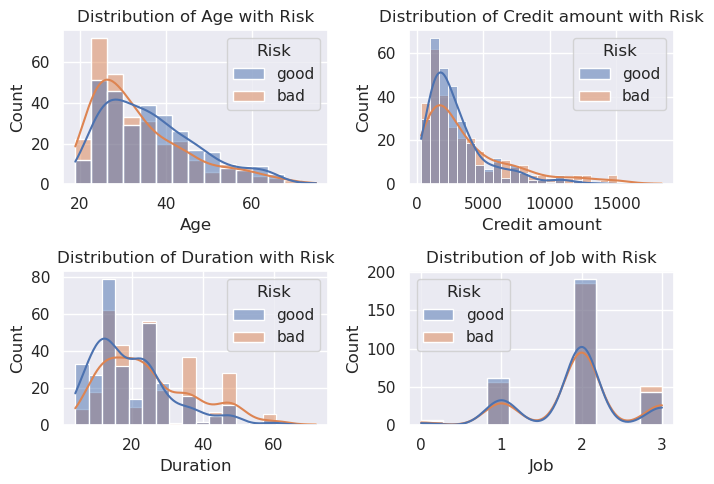

In [38]:
plt.figure(figsize=(7,5))
for index, col in enumerate(num_cols):
    plt.subplot(2,2, index+1)
    sns.histplot(x=col, hue='Risk', data= loan_data_sample, kde=True)
    plt.title(f'Distribution of {col} with Risk')
plt.tight_layout()

### Missing Values Imputation

##### To impute missing values , first of all we need to split our dataset into train and test set

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer

In [40]:
# Data Partitioning
train_set, test_set = train_test_split(loan_data, test_size=0.2, random_state=10)

In [41]:
train_set.describe().loc[['mean','std']]

,Unnamed: 0,Age,Job,Credit amount,Duration
mean,497.442500,35.443750,1.893750,3297.265000,21.042500
std,289.160222,11.464778,0.634795,2817.713676,12.108115


In [42]:
test_set.describe().loc[['mean','std']]

,Unnamed: 0,Age,Job,Credit amount,Duration
mean,507.730000,35.955000,1.945000,3167.230000,20.345000
std,288.027632,11.029562,0.724291,2847.463291,11.873114


##### As can be seen, our split looks normal

In [43]:
missing_values = train_set.isna().sum().sort_values(ascending=False).to_frame(name='missing_count')

no_of_rows = train_set.shape[0]
missing_values['Missing_percent']=np.round((missing_values['missing_count']/no_of_rows)*100,2)
missing_values

,missing_count,Missing_percent
Checking account,318,39.75
Saving accounts,154,19.25
Unnamed: 0,0,0.00
Age,0,0.00
Sex,0,0.00
Job,0,0.00
Housing,0,0.00
Credit amount,0,0.00
Duration,0,0.00
Purpose,0,0.00


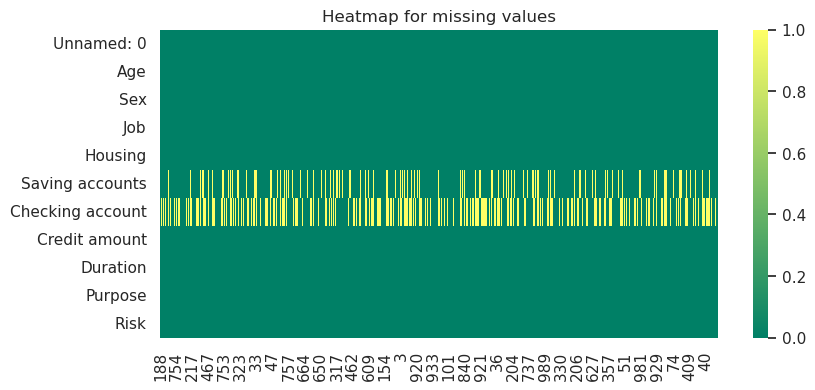

In [44]:
# Heatmap
plt.figure(figsize=(9,4))
sns.heatmap(train_set.isna().T, cmap='summer')
plt.title('Heatmap for missing values')
plt.show()

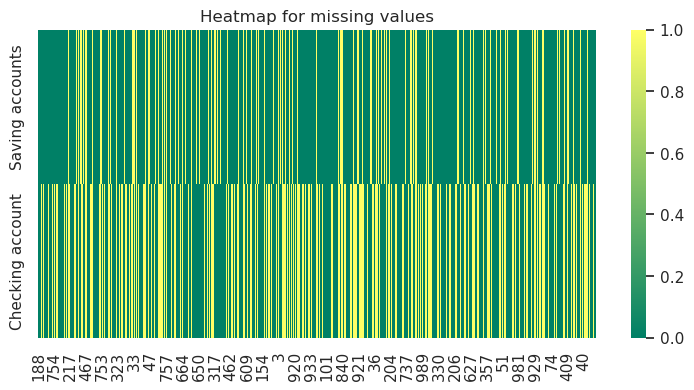

In [45]:
plt.figure(figsize=(9,4))
sns.heatmap(train_set.isna().T.loc[['Saving accounts', 'Checking account']], cmap='summer')
plt.title('Heatmap for missing values')
plt.show()

##### The missing values are at random index. So, we have to use appropriate method for imputing it.

In [46]:
# Taking balance data for easity to analyse
train_size = train_set.shape[0]
test_size = test_set.shape[0]

train_set_index = pd.RangeIndex(start=0, stop=train_size, step=1)
test_set_index = pd.RangeIndex(start= train_size, stop= train_size+test_size, step=1)

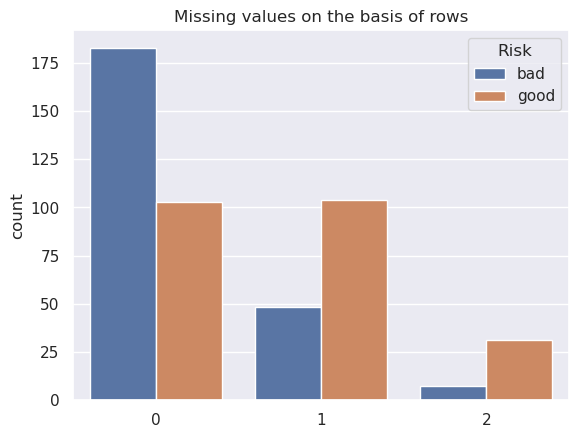

In [47]:
# Balance dataset
risk_bad_values = train_set[train_set['Risk']=='bad']
risk_good_values = train_set[train_set['Risk']=='good'].sample(risk_bad_values.shape[0])
# Concatenate
temp_df = pd.concat([risk_bad_values, risk_good_values])

missing_per_row = temp_df.isna().sum(axis=1)

sns.countplot(x= missing_per_row, hue=temp_df['Risk'])
plt.title('Missing values on the basis of rows')
plt.show()

##### Missing values in each features are independent of each others.

In [48]:
df_main = pd.concat([train_set, test_set])
df_main.shape

(1000, 11)

##### Though we have merged our train and test set. But, we will use train set information only to fill the missing values

In [49]:
train_set.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [50]:
train_set

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
188,188,20,male,2,own,moderate,little,674,12,radio/TV,bad
194,194,21,male,2,rent,moderate,moderate,3031,45,radio/TV,bad
225,225,27,male,2,own,little,NaN,2613,36,repairs,good
580,580,30,male,2,own,little,moderate,1056,18,car,bad
428,428,20,male,2,own,little,NaN,1313,9,furniture/equipment,good
...,...,...,...,...,...,...,...,...,...,...,...
320,320,28,male,3,own,little,moderate,4249,30,car,bad
527,527,42,male,1,own,little,NaN,1503,4,radio/TV,good
996,996,40,male,3,own,little,little,3857,30,car,good
125,125,30,male,2,own,little,little,2121,12,car,good


In [51]:
train_set[train_set['Job']==2][['Job','Saving accounts']].value_counts()

Job  Saving accounts
2    little             297
     moderate            56
     quite rich          34
     rich                24
dtype: int64

In [52]:
jsa_gb = train_set.groupby(['Job', 'Saving accounts'])['Unnamed: 0'].size().unstack().fillna(0)
jsa_gb.head()

Saving accounts,little,moderate,quite rich,rich
Job,,,,
0,9.0,0.0,2.0,1.0
1,100.0,21.0,9.0,7.0
2,297.0,56.0,34.0,24.0
3,72.0,8.0,4.0,2.0


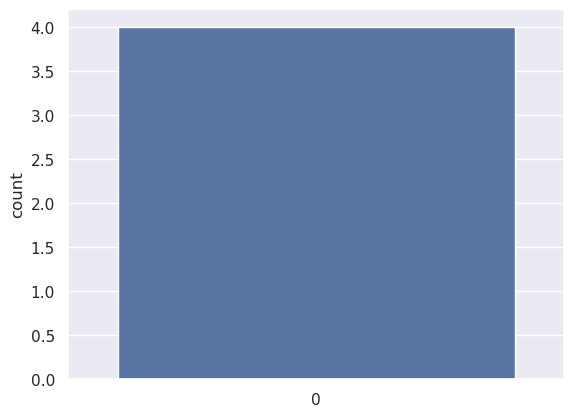

In [53]:
# Checking if each row in graoup distribution has only one value or not
sns.countplot((jsa_gb>0).sum(axis=1))
plt.show()

##### For each Job, we have almost same Saving accounts class. So, we will use Job feature to impute the missing values in Saving accounts

In [54]:
saving_account_nulls =df_main['Saving accounts'].isna().sum()

null_index = df_main[(df_main['Saving accounts'].isna()) & (df_main['Job'].isin(jsa_gb.index))].index

df_main.loc[null_index, 'Saving accounts'] = df_main.loc[null_index, 'Job'].apply(lambda x: jsa_gb.loc[x].idxmax())

# Analusing the situation of missing values
print(f"Missing values after imputation is {df_main['Saving accounts'].isna().sum()}")

Missing values after imputation is 0


In [55]:
train_set['Checking account'].value_counts()

little      219
moderate    216
rich         47
Name: Checking account, dtype: int64

##### Distribution of classes in Checking account feature is normal. So, we will impute the missing values by creating a new class.

In [56]:
df_main['Checking account'] = df_main['Checking account'].fillna('unknown') # Creating new class

In [57]:
# Function for updating our dataframe
def get_train_test(df):
    df_train = df_main.loc[df_main['Unnamed: 0'].isin(train_set['Unnamed: 0'])]   # Using 'Unnamed' for getting train and test set
    df_test = df_main.loc[df_main['Unnamed: 0'].isin(test_set['Unnamed: 0'])]
    
    return df_train, df_test

In [58]:
train_set, test_set = get_train_test(df_main)

### Feature Engineering

In [59]:
train_set.dtypes

Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

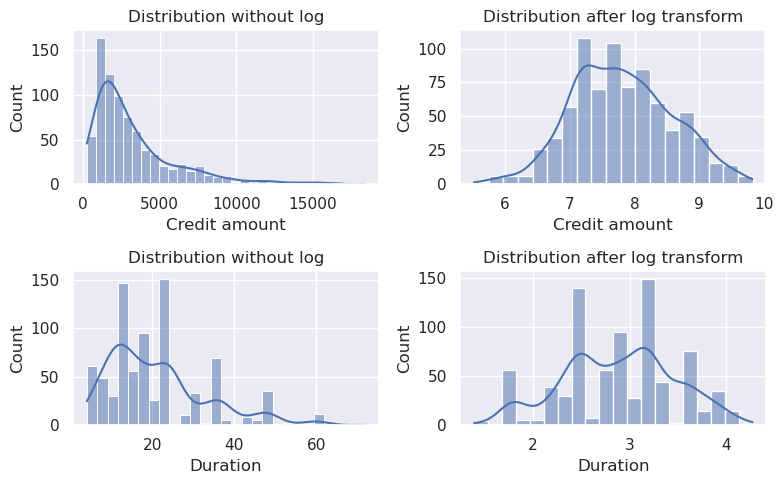

In [60]:
var=['Credit amount', 'Duration']

plt.figure(figsize=(8,5))
for index, col in enumerate(var):
    plt.subplot(2,2, 2*index+1)
    sns.histplot(train_set[col], kde=True)
    plt.title('Distribution without log')
    
    plt.subplot(2,2, 2*index+2)
    sns.histplot(x=np.log(train_set[col]), kde=True)
    plt.title('Distribution after log transform')
plt.tight_layout()

In [61]:
# Applying log transformation
for col in var:
    df_main[col] =np.log(df_main[col])

In [62]:
# Updating train and test set
train_set, test_set = get_train_test(df_main)

In [63]:
train_set

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
188,188,20,male,2,own,moderate,little,6.513230,2.484907,radio/TV,bad
194,194,21,male,2,rent,moderate,moderate,8.016648,3.806662,radio/TV,bad
225,225,27,male,2,own,little,unknown,7.868254,3.583519,repairs,good
580,580,30,male,2,own,little,moderate,6.962243,2.890372,car,bad
428,428,20,male,2,own,little,unknown,7.180070,2.197225,furniture/equipment,good
...,...,...,...,...,...,...,...,...,...,...,...
320,320,28,male,3,own,little,moderate,8.354439,3.401197,car,bad
527,527,42,male,1,own,little,unknown,7.315218,1.386294,radio/TV,good
996,996,40,male,3,own,little,little,8.257645,3.401197,car,good
125,125,30,male,2,own,little,little,7.659643,2.484907,car,good


In [64]:
# Sending all the categories to others whose frequency is less than 50.
count = df_main['Purpose'].value_counts()
threshold = 50

rep= count[count <+50].index
# Replacing the categories with others
df_main['Purpose'] = df_main['Purpose'].replace(rep, 'others')


In [65]:
df_main['Purpose'].value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
others                  46
Name: Purpose, dtype: int64

In [66]:
train_set, test_set = get_train_test(df_main)

In [67]:
df_main['Saving accounts'].value_counts()

little        786
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [68]:
# Dropping Unnamed feature
df_main.drop(columns=['Unnamed: 0'], inplace=True)
train_set.drop(columns=['Unnamed: 0'], inplace=True)
test_set.drop(columns=['Unnamed: 0'], inplace=True)

In [69]:
# Using sklearn, we will do feature transformation 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [70]:
train_set.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
188,20,male,2,own,moderate,little,6.513230,2.484907,radio/TV,bad
194,21,male,2,rent,moderate,moderate,8.016648,3.806662,radio/TV,bad
225,27,male,2,own,little,unknown,7.868254,3.583519,others,good


In [71]:
trnf_1 = ColumnTransformer([
    ('oe', OrdinalEncoder(categories=[['little', 'moderate', 'rich', 'quite rich']]), [4]),
    ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), [1,3,5,8])
], remainder='passthrough')

In [72]:
trnf_2 = ColumnTransformer([
    ('mms', MinMaxScaler(), slice(0,16))
])

In [73]:
# Creation of pipeline
pipeline = Pipeline([
    ('tf1', trnf_1),
    ('tf2', trnf_2)
])

In [74]:
# Fit our train and test set to pipeline
train_set_transformed = pipeline.fit_transform(train_set.iloc[:, :-1])
test_set_transformed = pipeline.transform(train_set.iloc[:, :-1])

In [75]:
# Encoding target feature also
risk_encode = LabelEncoder()
train_target_feature = risk_encode.fit_transform(train_set.iloc[:, -1])
test_target_feature = risk_encode.transform(test_set.iloc[:, -1])

##### As we know, the dataset is imbalanced. So, we should handle it properly using appropriate techniques

##### First of all, we train our model in the same imbalanced dataset and we will use f1 score as our metric

### Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [77]:
# Training logistic regression
log_reg = LogisticRegression()
log_reg.fit(train_set_transformed, train_target_feature)

LogisticRegression()

In [78]:
# Prediction of train_set
train_target_pred = log_reg.predict(train_set_transformed)

# Performace metrics
print(f'Accuracy score : {accuracy_score(train_target_feature, train_target_pred)}')
print(f'Precision score : {precision_score(train_target_feature, train_target_pred)}')
print(f'Recall score : {recall_score(train_target_feature, train_target_pred)}')
print(f'F1 score : {f1_score(train_target_feature, train_target_pred)}')

Accuracy score : 0.7425
Precision score : 0.7696969696969697
Recall score : 0.9039145907473309
F1 score : 0.8314238952536825


##### Taking F1 score as our performace metric, we have got 83% of accuracy

### Decision Tree Classifier

In [79]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=3)
# Fitting our data to decision tree model
dt_clf.fit(train_set_transformed, train_target_feature)

DecisionTreeClassifier(max_depth=3)

In [80]:
train_target_pred = dt_clf.predict(train_set_transformed)

# Performace metrics
print(f'Accuracy score : {accuracy_score(train_target_feature, train_target_pred)}')
print(f'Precision score : {precision_score(train_target_feature, train_target_pred)}')
print(f'Recall score : {recall_score(train_target_feature, train_target_pred)}')
print(f'F1 score : {f1_score(train_target_feature, train_target_pred)}')

Accuracy score : 0.73875
Precision score : 0.7362784471218207
Recall score : 0.9786476868327402
F1 score : 0.8403361344537815


##### Using Decision tree, we have got 84% of accuracy.

#### Training with balance dataset

In [81]:
# We will use SMOTE to balance our dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE()

train_set_bal, train_target_bal = smote.fit_resample(train_set_transformed, train_target_feature)

In [82]:
# Checking the distribution of classes in target feature
print(f' Total number of 0 : {len(train_target_bal[train_target_bal==0])}')
print(f'Total number if 1 : {len(train_target_bal[train_target_bal==1])}')

 Total number of 0 : 562
Total number if 1 : 562


##### As can be seen, our dataset is normally distributed now

In [83]:
# Now, again using our dataset to train the same models
# Training logistic regression
log_reg = LogisticRegression()
log_reg.fit(train_set_bal, train_target_bal)

LogisticRegression()

In [84]:
# Prediction of train_set
train_target_pred = log_reg.predict(train_set_bal)

# Performace metrics
print(f'Accuracy score : {accuracy_score(train_target_bal, train_target_pred)}')
print(f'Precision score : {precision_score(train_target_bal, train_target_pred)}')
print(f'Recall score : {recall_score(train_target_bal, train_target_pred)}')
print(f'F1 score : {f1_score(train_target_bal, train_target_pred)}')

Accuracy score : 0.7090747330960854
Precision score : 0.7263969171483622
Recall score : 0.6708185053380783
F1 score : 0.6975023126734504


In [85]:
# Training descision tree
dt_clf = DecisionTreeClassifier(max_depth=3)
# Fitting our data to decision tree model
dt_clf.fit(train_set_bal, train_target_bal)

DecisionTreeClassifier(max_depth=3)

In [86]:
train_target_pred = dt_clf.predict(train_set_bal)

# Performace metrics
print(f'Accuracy score : {accuracy_score(train_target_bal, train_target_pred)}')
print(f'Precision score : {precision_score(train_target_bal, train_target_pred)}')
print(f'Recall score : {recall_score(train_target_bal, train_target_pred)}')
print(f'F1 score : {f1_score(train_target_bal, train_target_pred)}')

Accuracy score : 0.7215302491103203
Precision score : 0.7276051188299817
Recall score : 0.708185053380783
F1 score : 0.7177637511271415


### Conclusion

##### Though our accuracy has descreased, it provides realistic prediction while we use the code in production. We could use more models but, this time use do not do that. So, taking only two models, we have got best accuracy from Decision tree.

In [87]:
# Predicting the Test set
test_set_pred = dt_clf.predict(test_set_transformed)
test_set_pred

array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,